In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,Activation,add,multiply
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import regularizers
from keras.layers.merge import concatenate
from keras.layers.core import Lambda
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
im_width = 224
im_height = 224
border = 5
path_train = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train/'
path_test = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/test/'

In [3]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), 224, 224, 3), dtype=np.uint8)
    y = np.zeros((len(ids), 224, 224, 1), dtype=np.bool)

    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        # img = load_img(path + '/image/' + id_, grayscale=False)
        img = imread(path + '/image/' + id_)[:, :, :3]
        img = resize(img, (224, 224), mode='constant', preserve_range=True)
        X[n] = img
#         id_ = list(id_)
#         id_[3] = 'y'
#         string = ''.join(id_)
        mask = img_to_array(load_img(path + 'mask/' + id_, grayscale=True))
        mask = resize(mask, (224, 224, 1), mode='constant', preserve_range=True)

        X[n] = img
        y[n] = mask
    return X, y

In [4]:
X_train, Y_train = get_data(path_train, train=True)
X_valid, Y_valid = get_data(path_test,train=True)

Getting and resizing images ... 


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Getting and resizing images ... 


In [5]:
#X_train, Y_train = get_data(path_train, train=True)
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [6]:
#X_train, Y_train = get_data(path_train, train=True)
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator()
mask_datagen = image.ImageDataGenerator()

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_valid, seed=seed)
mask_datagen.fit(Y_valid, seed=seed)

x_val=image_datagen.flow(X_valid,batch_size=BATCH_SIZE,seed=seed)
y_val=mask_datagen.flow(Y_valid,batch_size=BATCH_SIZE,seed=seed)

In [7]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)
smooth = 1

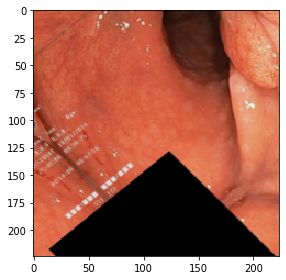

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


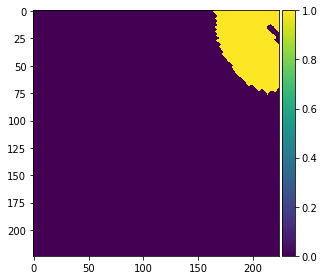

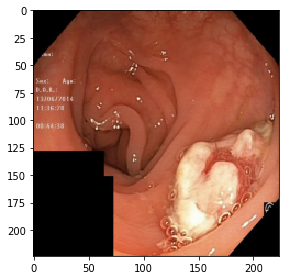

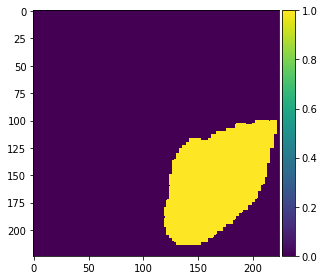

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [9]:
def dice_coef(y_true, y_pred):# y_true为真实准确值，y_pred为预测值
    y_true_f = K.flatten(y_true)# 捋直
    y_pred_f = K.flatten(y_pred)# 捋直
    # K.sum不加axi（指定方向求和，返回对应方向向量）,则为全元素求和，返回一个数字
    intersection = K.sum(y_true_f * y_pred_f)# 求预测准确的结果（真实准确值和预测值的交集）
    # 原始公式：（2*预测准确值）/（真实准确值+预测值），越大效果越好
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [49]:
# # from segmentation_models import Unet, Nestnet, Xnet
# # model = Xnet(backbone_name='resnet50', encoder_weights='imagenet', decoder_block_type='transpose')
# # print(model.summary())
# import efficientnet.keras as efn
# from keras.models import Model
# from keras.layers.convolutional import Conv2D
# from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout,Activation,add,multiply
# base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(None,None,3))
# input_1 = base_model.get_layer('input_1').output
# input_model = base_model.input
# start_neurons = 8
# dropout_ratio = 0.1

# def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
#     x = Conv2D(filters, size, strides=strides, padding=padding)(x)
#     x = BatchNormalization()(x)
#     if activation == True:
#         x = LeakyReLU(alpha=0.1)(x)
#     return x
# def residual_block(blockInput, num_filters=16):
#     x = LeakyReLU(alpha=0.1)(blockInput)
#     x = BatchNormalization()(x)
#     blockInput = BatchNormalization()(blockInput)
#     x = convolution_block(x, num_filters, (3, 3))
#     x = convolution_block(x, num_filters, (3, 3), activation=False)
#     x = Add()([x, blockInput])
#     return x
# def attention(first_layer, second_layer,number_of_channel):
#     first = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(first_layer)
#     second = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(second_layer)
#     f = Activation('relu')(add([first, second]))

#     psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
#     rate = Activation('sigmoid')(psi_f)

#     att_x = multiply([first, rate])
#     return att_x

# def reduce_dimension(layer, n):
#     layer = MaxPool2D(pool_size=(n,n),padding='same')(layer)
#     return layer

# conv5 = base_model.get_layer('top_activation').output
# conv4 = base_model.get_layer('block6a_expand_activation').output
# conv3 = base_model.get_layer('block4a_expand_activation').output
# conv2 = base_model.get_layer('block3a_expand_activation').output
# conv1 = base_model.get_layer('block2a_expand_activation').output

# reduce_layer_conv1 = reduce_dimension(conv1,2)
# # reduce_layer_conv1 = LeakyReLU(alpha=0.1)(reduce_layer_conv1)
# # reduce_layer_conv1 = BatchNormalization()(reduce_layer_conv1)
# reduce_layer_conv1 = reduce_dimension(reduce_layer_conv1,2)
# # reduce_layer_conv1 = LeakyReLU(alpha=0.1)(reduce_layer_conv1)
# # reduce_layer_conv1 = BatchNormalization()(reduce_layer_conv1)

# reduce_layer_conv2 = reduce_dimension(conv2,2)
# # reduce_layer_conv2 = LeakyReLU(alpha=0.1)(reduce_layer_conv2)
# # reduce_layer_conv2 = BatchNormalization()(reduce_layer_conv2)

# reduce_layer_conv3 = conv3

# up_layer_conv4 = Conv2DTranspose(240,(3,3),strides=(2,2),padding="same")(conv4)
# up_layer_conv4 = LeakyReLU(alpha=0.1)(up_layer_conv4)
# up_layer_conv4 = BatchNormalization()(up_layer_conv4)

# up_layer_conv5 = Conv2DTranspose(672,(3,3),strides=(2,2),padding="same")(conv5)
# up_layer_conv5 = LeakyReLU(alpha=0.1)(up_layer_conv5)
# up_layer_conv5 = BatchNormalization()(up_layer_conv5)
# up_layer_conv5 = Conv2DTranspose(240,(3,3),strides=(2,2),padding="same")(up_layer_conv5)
# up_layer_conv5 = LeakyReLU(alpha=0.1)(up_layer_conv5)
# up_layer_conv5 = BatchNormalization()(up_layer_conv5)

# merged_global_features = concatenate([reduce_layer_conv1,reduce_layer_conv2,reduce_layer_conv3,up_layer_conv4,up_layer_conv5])
# merged_global_features = Conv2D(960, (1, 1), strides=1, padding="same")(merged_global_features)
# merged_global_features = LeakyReLU(alpha=0.1)(merged_global_features)
# merged_global_features = BatchNormalization()(merged_global_features)

# #Middle 7*7
# convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(conv5)
# convm = residual_block(convm,start_neurons * 32)
# convm = residual_block(convm,start_neurons * 32)
# convm = LeakyReLU(alpha=0.1)(convm) #7*7

# #14*14
# merged_global_features_reduced_2 = reduce_dimension(merged_global_features,2)
# merged_global_features_reduced_2 = Conv2D(672, (3, 3), activation='relu', padding="same",name='merged_global_features_reduced_2')(merged_global_features_reduced_2)
# merged_global_features_reduced_2 = BatchNormalization()(merged_global_features_reduced_2)
# deconv4_attention = attention(conv4,merged_global_features_reduced_2,672)
# deconv4 = Conv2DTranspose(start_neurons*16,(3,3),strides=(2,2),padding="same")(convm)
# uconv4 = concatenate([deconv4,deconv4_attention])
# uconv4 = Dropout(dropout_ratio)(uconv4)
# uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
# uconv4 = residual_block(uconv4,start_neurons * 16)
# uconv4 = LeakyReLU(alpha=0.1)(uconv4)

# #28*28
# merged_global_features_no_reduce = Conv2D(240, (3, 3), activation='relu', padding="same",name='merged_global_features_no_reduce')(merged_global_features)
# deconv3_attention = attention(conv3,merged_global_features_no_reduce,240)
# deconv3 = Conv2DTranspose(start_neurons*8,(3,3),strides=(2,2),padding="same")(uconv4)
# uconv3 = concatenate([deconv3,deconv3_attention])
# uconv3 = Dropout(dropout_ratio)(uconv3)
# uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
# uconv3 = residual_block(uconv3,start_neurons * 8)
# uconv3 = LeakyReLU(alpha=0.1)(uconv3)

# #56*56
# merged_global_features_up_2 = Conv2DTranspose(144,(3,3),strides=(2,2),padding="same")(merged_global_features)
# merged_global_features_up_2 = LeakyReLU(alpha=0.1)(merged_global_features_up_2)
# merged_global_features_up_2 = BatchNormalization()(merged_global_features_up_2)
# deconv2_attention = attention(conv2,merged_global_features_up_2,144)
# deconv2 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2,2),padding="same")(uconv3)
# uconv2 = concatenate([deconv2,deconv2_attention])
# uconv2 = Dropout(dropout_ratio)(uconv2)
# uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
# uconv2 = residual_block(uconv2,start_neurons * 4)
# uconv2 = LeakyReLU(alpha=0.1)(uconv2)

# #112*112
# merged_global_features_up_4 = Conv2DTranspose(144,(3,3),strides=(2,2),padding="same")(merged_global_features)
# merged_global_features_up_4 = LeakyReLU(alpha=0.1)(merged_global_features_up_4)
# merged_global_features_up_4 = BatchNormalization()(merged_global_features_up_4)
# merged_global_features_up_4 = Conv2DTranspose(96,(3,3),strides=(2,2),padding="same")(merged_global_features_up_4)
# merged_global_features_up_4 = LeakyReLU(alpha=0.1)(merged_global_features_up_4)
# merged_global_features_up_4 = BatchNormalization()(merged_global_features_up_4)
# deconv1_attention = attention(conv1,merged_global_features_up_4,96)
# deconv1 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2,2),padding="same")(uconv2)
# uconv1 = concatenate([deconv1,deconv1_attention])
# uconv1 = Dropout(dropout_ratio)(uconv1)
# uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
# uconv1 = residual_block(uconv1,start_neurons * 2)
# uconv1 = LeakyReLU(alpha=0.1)(uconv1)

# #224*224
# deconv0 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2,2),padding="same")(uconv1)
# uconv0 = Dropout(dropout_ratio)(deconv0)
# uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
# uconv0 = residual_block(uconv0,start_neurons * 1)
# uconv0 = LeakyReLU(alpha=0.1)(uconv0)

# output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)

# model = Model(input_model,[output_layer])
# print(model.summary())
# from keras.optimizers import Adam
# model.compile(optimizer=Adam(lr = 0.001),loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
# # Fit model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# tensorboard = TensorBoard(log_dir='./proposed',histogram_freq=0,write_graph=True,write_images=False)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                    patience=3, min_lr=0.00001, verbose=1,cooldown=1)
# earlystopper = EarlyStopping(patience=10, verbose=1)
# checkpointer = ModelCheckpoint('proposed.h5', verbose=1, save_best_only=True)
# results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
#                               epochs=100, callbacks=[tensorboard, checkpointer,reduce_lr,earlystopper])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
___________________________________________________________________________________________

Epoch 1/100
250/250 [==============================] - 82s 328ms/step - loss: 0.2417 - dice_coef: 0.6320 - mean_iou: 0.6462 - val_loss: 0.3051 - val_dice_coef: 0.7505 - val_mean_iou: 0.7253

Epoch 00001: val_loss improved from inf to 0.30512, saving model to proposed.h5
Epoch 2/100
250/250 [==============================] - 68s 272ms/step - loss: 0.1443 - dice_coef: 0.7635 - mean_iou: 0.7474 - val_loss: 0.1627 - val_dice_coef: 0.8393 - val_mean_iou: 0.7640

Epoch 00002: val_loss improved from 0.30512 to 0.16275, saving model to proposed.h5
Epoch 3/100
250/250 [==============================] - 68s 272ms/step - loss: 0.1219 - dice_coef: 0.8005 - mean_iou: 0.7746 - val_loss: 0.1023 - val_dice_coef: 0.8314 - val_mean_iou: 0.7837

Epoch 00003: val_loss improved from 0.16275 to 0.10234, saving model to proposed.h5
Epoch 4/100
250/250 [==============================] - 68s 273ms/step - loss: 0.1106 - dice_coef: 0.8189 - mean_iou: 0.7899 - val_loss: 0.1411 - val_dice_coef: 0.8417 - val_mean_i


Epoch 00032: val_loss did not improve from 0.07909
Epoch 00032: early stopping


In [11]:
import efficientnet.keras as efn
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout,Activation,add,multiply
base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(None,None,3))
input_model = base_model.input
start_neurons = 8
dropout_ratio = 0.1

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x
def attention(first_layer, second_layer,number_of_channel):
    first = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(first_layer)
    second = Conv2D(number_of_channel, [1, 1], strides=[1, 1])(second_layer)
    f = Activation('relu')(add([first, second]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([first, rate])
    return att_x

def reduce_dimension(layer, n):
    layer = MaxPool2D(pool_size=(n,n),padding='same')(layer)
    return layer

conv5 = base_model.get_layer('top_activation').output
conv4 = base_model.get_layer('block6a_expand_activation').output
conv3 = base_model.get_layer('block4a_expand_activation').output
conv2 = base_model.get_layer('block3a_expand_activation').output
conv1 = base_model.get_layer('block2a_expand_activation').output

# input_1 = base_model.get_layer('input_1').output
# deconv_input1 = Conv2DTranspose(32,(3,3),strides=(2,2),padding="same")(input_1)
# deconv_input1_1st = Conv2D(32, (1, 1), strides=1, padding="same")(deconv_input1)
# deconv_input1_1st = BatchNormalization()(deconv_input1_1st)
# deconv_input1_1st = LeakyReLU(alpha=0.1)(deconv_input1_1st)
# deconv_input1_1st = reduce_dimension(deconv_input1_1st,2)
# deconv_input1_1st = Conv2D(64, (1, 1), strides=1, padding="same")(deconv_input1_1st)
# deconv_input1_1st = BatchNormalization()(deconv_input1_1st)
# deconv_input1_1st = LeakyReLU(alpha=0.1)(deconv_input1_1st)
# deconv_input1_1st = reduce_dimension(deconv_input1_1st,2)
# deconv_input1_1st = Conv2D(96, (1, 1), strides=1, padding="same")(deconv_input1_1st)
# deconv_input1_1st = BatchNormalization()(deconv_input1_1st)
# deconv_input1_1st = LeakyReLU(alpha=0.1)(deconv_input1_1st)


#Middle 7*7
convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(conv5)
convm = residual_block(convm,start_neurons * 32)
convm = residual_block(convm,start_neurons * 32)
convm = LeakyReLU(alpha=0.1)(convm) #7*7

#14*14
deconv4 = Conv2DTranspose(start_neurons*16,(3,3),strides=(2,2),padding="same")(convm)
uconv4 = concatenate([deconv4,conv4])
uconv4 = Dropout(dropout_ratio)(uconv4)
uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 16)
uconv4 = LeakyReLU(alpha=0.1)(uconv4)

#28*28
deconv3 = Conv2DTranspose(start_neurons*8,(3,3),strides=(2,2),padding="same")(uconv4)
uconv3 = concatenate([deconv3,conv3])
uconv3 = Dropout(dropout_ratio)(uconv3)
uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 8)
uconv3 = LeakyReLU(alpha=0.1)(uconv3)

#56*56
deconv2 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2,2),padding="same")(uconv3)
uconv2 = concatenate([deconv2,conv2])
uconv2 = Dropout(dropout_ratio)(uconv2)
uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 4)
uconv2 = LeakyReLU(alpha=0.1)(uconv2)

#112*112
deconv1 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2,2),padding="same")(uconv2)
uconv1 = concatenate([deconv1,conv1])
uconv1 = Dropout(dropout_ratio)(uconv1)
uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 2)
uconv1 = LeakyReLU(alpha=0.1)(uconv1)

#224*224
deconv0 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2,2),padding="same")(uconv1)
uconv0 = Dropout(dropout_ratio)(deconv0)
uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = residual_block(uconv0,start_neurons * 1)
uconv0 = LeakyReLU(alpha=0.1)(uconv0)

output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)
model = Model(input_model,[output_layer])
print(model.summary())
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr = 0.001),loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
tensorboard = TensorBoard(log_dir='./check3',histogram_freq=0,write_graph=True,write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=3, min_lr=0.00001, verbose=1,cooldown=1)
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('check3.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[tensorboard, checkpointer,reduce_lr,earlystopper])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Epoch 1/5
250/250 [==============================] - 53s 213ms/step - loss: 0.2796 - dice_coef: 0.5973 - mean_iou: 0.6302 - val_loss: 0.1858 - val_dice_coef: 0.7188 - val_mean_iou: 0.7076

Epoch 00001: val_loss improved from inf to 0.18577, saving model to check3.h5
Epoch 2/5
250/250 [==============================] - 41s 165ms/step - loss: 0.1526 - dice_coef: 0.7439 - mean_iou: 0.7310 - val_loss: 0.1874 - val_dice_coef: 0.8211 - val_mean_iou: 0.7487

Epoch 00002: val_loss did not improve from 0.18577
Epoch 3/5
250/250 [==============================] - 41s 165ms/step - loss: 0.1275 - dice_coef: 0.7915 - mean_iou: 0.7621 - val_loss: 0.1079 - val_dice_coef: 0.8583 - val_mean_iou: 0.7713

Epoch 00003: val_loss improved from 0.18577 to 0.10793, saving model to check3.h5
Epoch 4/5
250/250 [==============================] - 41s 165ms/step - loss: 0.1132 - dice_coef: 0.8128 - mean_iou: 0.7791 - val_loss: 0.1364 - val_dice_coef: 0.8546 - val_mean_iou: 0.7861

Epoch 00004: val_loss did not imp

In [12]:
from keras.preprocessing import image

img_path = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/train/image/cju0qkwl35piu0993l0dewei2.jpg'

img = imread(img_path)[:, :, :3]
img = resize(img, (224, 224), mode='constant', preserve_range=True)
img = np.expand_dims(img, axis=0)
# We preprocess the image into a 4D tensor
# img = image.load_img(img_path, target_size=(224, 224))
# img_tensor = image.img_to_array(img)
# print(img_tensor.shape)
# img_tensor1 = np.expand_dims(img_tensor, axis=0)
# print(img_tensor1.shape)
# img_tensor2 = preprocess_input(img_tensor1)

print(img.shape)

(1, 224, 224, 3)


In [13]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_2
1 stem_conv
2 stem_bn
3 stem_activation
4 block1a_dwconv
5 block1a_bn
6 block1a_activation
7 block1a_se_squeeze
8 block1a_se_reshape
9 block1a_se_reduce
10 block1a_se_expand
11 block1a_se_excite
12 block1a_project_conv
13 block1a_project_bn
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_dwconv
18 block2a_bn
19 block2a_activation
20 block2a_se_squeeze
21 block2a_se_reshape
22 block2a_se_reduce
23 block2a_se_expand
24 block2a_se_excite
25 block2a_project_conv
26 block2a_project_bn
27 block2b_expand_conv
28 block2b_expand_bn
29 block2b_expand_activation
30 block2b_dwconv
31 block2b_bn
32 block2b_activation
33 block2b_se_squeeze
34 block2b_se_reshape
35 block2b_se_reduce
36 block2b_se_expand
37 block2b_se_excite
38 block2b_project_conv
39 block2b_project_bn
40 block2b_drop
41 block2b_add
42 block3a_expand_conv
43 block3a_expand_bn
44 block3a_expand_activation
45 block3a_dwconv
46 block3a_bn
47 block3a_activation
48 block3a_se_squeeze
49 block3

(1, 14, 14, 128)


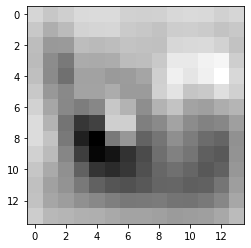

In [24]:
from keras.models import Model
from numpy import expand_dims
from matplotlib import pyplot
model = Model(inputs=model.inputs, outputs=model.layers[-7].output)
# load the image with the required shape
img = load_img('/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/train/image/cju0qkwl35piu0993l0dewei2.jpg', target_size=(224, 224))
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
print(feature_maps.shape)
# plot the output from each block
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
result = []
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
# 		ax = pyplot.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
		# plot filter channel in grayscale
		#pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		result.append(feature_maps[0, :, :, ix-1]) 
		ix += 1
image = np.mean(result,axis=0)
pyplot.imshow(image,cmap='gray')
# show the figure
pyplot.show()

In [13]:
preds = model.predict(img)
print(preds)

[[[[0.05657287]
   [0.04182177]
   [0.03170435]
   ...
   [0.02084764]
   [0.0347553 ]
   [0.04036684]]

  [[0.03412377]
   [0.02810475]
   [0.01744669]
   ...
   [0.0080868 ]
   [0.02170626]
   [0.02951881]]

  [[0.02645558]
   [0.01470119]
   [0.01607117]
   ...
   [0.00685312]
   [0.01331481]
   [0.02873078]]

  ...

  [[0.01991486]
   [0.00891588]
   [0.006821  ]
   ...
   [0.00598657]
   [0.01501474]
   [0.0201355 ]]

  [[0.02512115]
   [0.0117873 ]
   [0.00973945]
   ...
   [0.0099772 ]
   [0.01605478]
   [0.02929354]]

  [[0.05008308]
   [0.03321707]
   [0.02825509]
   ...
   [0.02514987]
   [0.03589907]
   [0.04905894]]]]


In [17]:
np.argmax(preds[0])

29217

In [20]:
from keras import backend as K
# This is the "adenoma image" entry in the prediction vector
uc = model.output[:, np.argmax(preds[0])]

# # The is the output feature map of the `block5_conv3` layer,
# # the last convolutional layer in ResNet50
last_conv_layer = model.get_layer('leaky_re_lu_20')

# # This is the gradient of the "adenoma image" class with regard to
# # the output feature map of `res2a_branch2a`
grads = K.gradients(uc, last_conv_layer.output)[0]

# # This is a vector of shape (2048,), where each entry
# # is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# # This function allows us to access the values of the quantities we just defined:
# # `pooled_grads` and the output feature map of `res5c_branch2c`,
# # given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# # These are the values of these two quantities, as Numpy arrays,
# # given our sample image of colitis
pooled_grads_value, conv_layer_output_value = iterate([img])

# # We multiply each channel in the feature map array
# # by "how important this channel is" with regard to the adenoma class
for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# # The channel-wise mean of the resulting feature map
# # is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
#heatmap = conv_layer_output_value[:, :, 11]

InvalidArgumentError: slice index 29217 of dimension 1 out of bounds.
	 [[Node: strided_slice_2 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@gradients_1/strided_slice_2_grad/StridedSliceGrad"], begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_20/Sigmoid-2-0-TransposeNCHWToNHWC-LayoutOptimizer, strided_slice_2/stack, strided_slice_2/stack_1, strided_slice_2/stack_2)]]

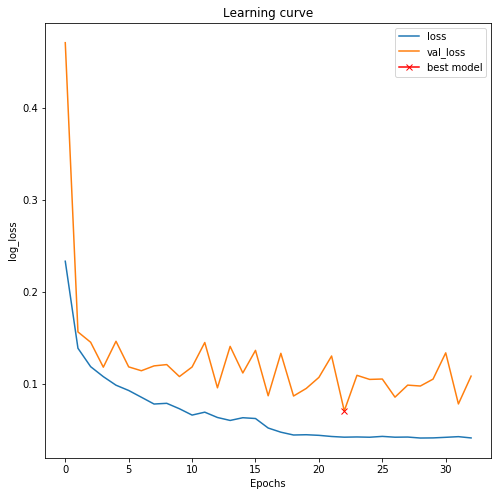

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

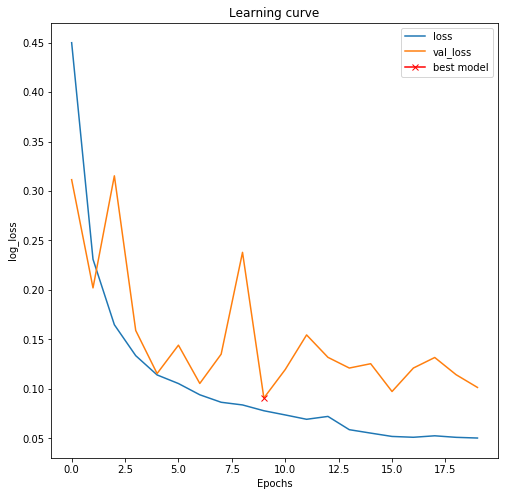

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [19]:
#from segmentation_models import Unet, Nestnet, Xnet
# model = Nestnet(backbone_name='resnet50', encoder_weights='imagenet', decoder_block_type='transpose')
#model.load_weights('/home/poudelas/Documents/UNetPlusPlus-master/Ksavir.h5')
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


# # Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_val)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_val_t[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))

105/105 [==============================] - 0s 3ms/step


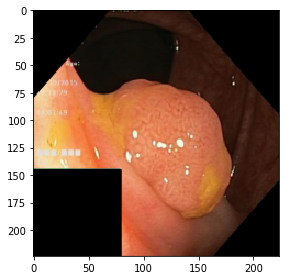

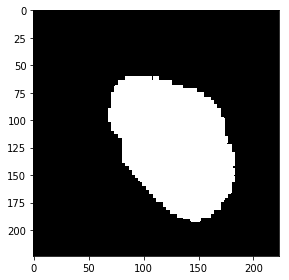

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


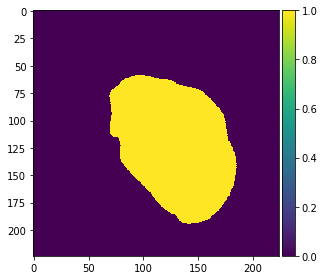

In [51]:

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

(105, 224, 224, 1)


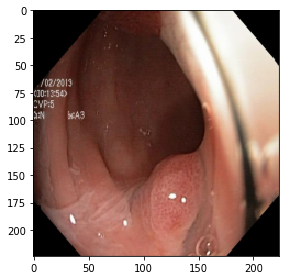

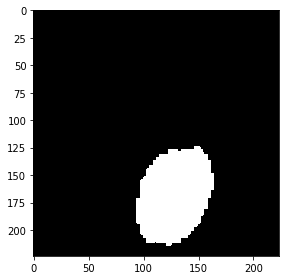

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


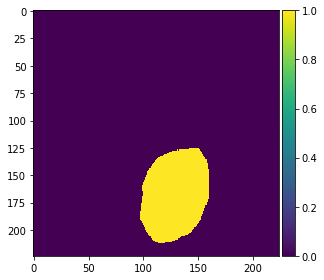

In [20]:
import cv2
print(preds_val_t.shape)
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_valid[ix])
plt.show()
imshow(np.squeeze(Y_valid[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
# img = np.squeeze(Y_valid[ix])
# img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
# img = cv2.convertScaleAbs(img)
# cv2.imwrite('resized_image'+str(ix)+'.jpg',img)
# for i in range(len(preds_val_t)):
#     cv2.imwrite('./visualize/resized_image'+str(i)+'.jpg',img)
   
    
    

In [21]:
for i in range(len(preds_val_t)):
    cv2.imwrite('/home/poudelas/Documents/visualize/Ksavir_dataset/simple_unet/image/original'+str(i)+'.jpg',cv2.cvtColor(X_valid[i], cv2.COLOR_BGR2RGB))
    cv2.imwrite('/home/poudelas/Documents/visualize/Ksavir_dataset/simple_unet/mask/mask'+str(i)+'.jpg',np.squeeze(Y_valid[i]*255))

In [22]:
for i in range(len(preds_val_t)):
    #cv2.imwrite('./visualize/Unet_plus_plus/image/original'+str(i)+'.jpg',cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    cv2.imwrite('/home/poudelas/Documents/visualize/Ksavir_dataset/simple_unet/predicted/mask'+str(i)+'.jpg',np.squeeze(preds_val_t[i]*255))

In [24]:
preds_val = model.evaluate(X_valid,Y_valid, verbose=1)
print(preds_val[0])
print(preds_val[1])
print(preds_val[2])

105/105 [==============================] - 1s 5ms/step
0.1029150475348745
0.8960400859514872
0.8960077910196214
